# Start by reproducing previous results in a single example

(Huang, Chang 2025 Causality  $\ne$ Decodability)

- CLS token decodability by linear probing increases in the middle of the network, while causality remains low.
- 

(Vilas et al 2023 Analyzing Vision Transformers for Image Classification in Class Embedding Space)

- Using the classification read-out as a probe, shows high identifiability score based on relative position of the ground-truth logit




In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch

In [2]:
from initialization import setup_model_ds_collator_images
from training import run_probe_training

model_name = "google/vit-base-patch16-224"
dataset_name = "zh-plus/tiny-imagenet"

W0111 13:01:01.430000 39449 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


import error: No module named 'triton'


In [3]:
_, ds, collator = setup_model_ds_collator_images('google/vit-base-patch16-224', dataset_name)
ds['test'] = ds['valid']

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import AutoModelForImageClassification
model = AutoModelForImageClassification.from_pretrained('test/probe/checkpoint-1563/')
model = model.eval().to('mps')

In [5]:
from analysis import run_across_layers, apply_model_decoder, accuracy_random_CLS, linear_probe_by_ridge_regression

## Identifiability across layers

Using the output probing and identifiability metrics from (Vilas et al 2023)

In [6]:
identifiabilityResults = run_across_layers(model, ds, apply_model_decoder, 'vit.encoder.layer.{ind}', 12)

📕 Analysis: <function apply_model_decoder at 0x333e937e0>
📄 Layer: vit.encoder.layer.0


100%|███████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]


📄 Layer: vit.encoder.layer.1


100%|███████████████████████████████████████████| 79/79 [00:56<00:00,  1.41it/s]


📄 Layer: vit.encoder.layer.2


100%|███████████████████████████████████████████| 79/79 [00:58<00:00,  1.34it/s]


📄 Layer: vit.encoder.layer.3


100%|███████████████████████████████████████████| 79/79 [00:59<00:00,  1.33it/s]


📄 Layer: vit.encoder.layer.4


100%|███████████████████████████████████████████| 79/79 [00:56<00:00,  1.40it/s]


📄 Layer: vit.encoder.layer.5


100%|███████████████████████████████████████████| 79/79 [00:58<00:00,  1.36it/s]


📄 Layer: vit.encoder.layer.6


100%|███████████████████████████████████████████| 79/79 [01:02<00:00,  1.27it/s]


📄 Layer: vit.encoder.layer.7


100%|███████████████████████████████████████████| 79/79 [01:02<00:00,  1.26it/s]


📄 Layer: vit.encoder.layer.8


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]


📄 Layer: vit.encoder.layer.9


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:05<00:00,  1.21it/s]


📄 Layer: vit.encoder.layer.10


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]


📄 Layer: vit.encoder.layer.11


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:06<00:00,  1.19it/s]


In [7]:
identifiabilityResults

,name,accuracy,identifiability,test
0,vit.encoder.layer.0,0.0075,0.516317,layerwise_model_decoder
1,vit.encoder.layer.1,0.0084,0.532526,layerwise_model_decoder
2,vit.encoder.layer.2,0.0081,0.558976,layerwise_model_decoder
3,vit.encoder.layer.3,0.0111,0.610155,layerwise_model_decoder
4,vit.encoder.layer.4,0.0187,0.658626,layerwise_model_decoder
5,vit.encoder.layer.5,0.0294,0.708623,layerwise_model_decoder
6,vit.encoder.layer.6,0.0454,0.747594,layerwise_model_decoder
7,vit.encoder.layer.7,0.0570,0.767734,layerwise_model_decoder
8,vit.encoder.layer.8,0.0683,0.787933,layerwise_model_decoder
9,vit.encoder.layer.9,0.1019,0.827522,layerwise_model_decoder


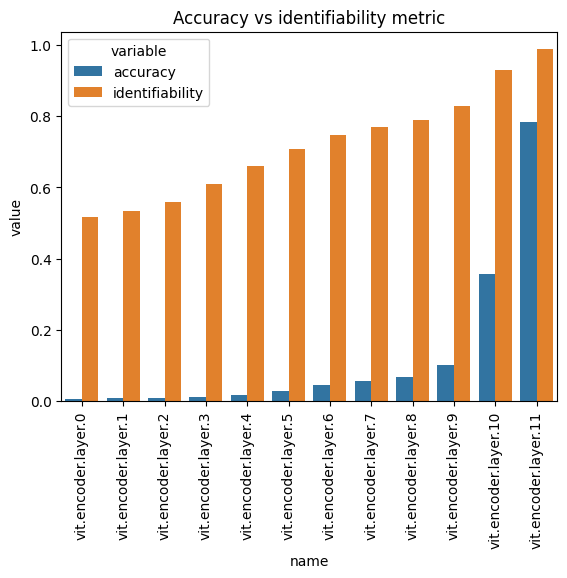

In [8]:
sns.barplot(identifiabilityResults.melt(id_vars=['name', 'test']), x='name', y='value', hue='variable')
plt.title('Accuracy vs identifiability metric')
_= plt.xticks(rotation=90)


## Causal effect:

Next, verify the impact of CLS token shuffling within the model.

In [9]:
randomized_accuracy = run_across_layers(model, ds, accuracy_random_CLS, 'vit.encoder.layer.{ind}', 12)

📕 Analysis: <function accuracy_random_CLS at 0x333e92e80>
📄 Layer: vit.encoder.layer.0


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:03<00:00,  1.25it/s]


📄 Layer: vit.encoder.layer.1


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:01<00:00,  1.29it/s]


📄 Layer: vit.encoder.layer.2


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.34it/s]


📄 Layer: vit.encoder.layer.3


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:57<00:00,  1.38it/s]


📄 Layer: vit.encoder.layer.4


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.36it/s]


📄 Layer: vit.encoder.layer.5


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:57<00:00,  1.38it/s]


📄 Layer: vit.encoder.layer.6


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:57<00:00,  1.38it/s]


📄 Layer: vit.encoder.layer.7


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.35it/s]


📄 Layer: vit.encoder.layer.8


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.39it/s]


📄 Layer: vit.encoder.layer.9


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:56<00:00,  1.40it/s]


📄 Layer: vit.encoder.layer.10


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.41it/s]


📄 Layer: vit.encoder.layer.11


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:55<00:00,  1.42it/s]


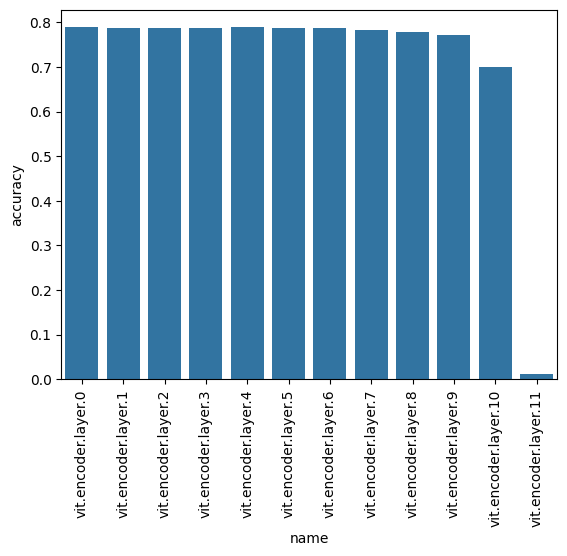

In [10]:
sns.barplot(randomized_accuracy, x='name', y='accuracy')
_= plt.xticks(rotation=90)

#### Double check the hooks

In [11]:
print("Hooks after")
for name, module in model.named_modules():
    if hasattr(module, '_forward_hooks') and module._forward_hooks:
        print(f"Module: {name}, _forward_hooks: {list(module._forward_hooks.keys())}")
    if hasattr(module, '_backward_hooks') and module._backward_hooks:
        print(f"Module: {name}, _backward_hooks: {list(module._backward_hooks.keys())}")


Hooks after


## Linear probes

Per-layer linear probe to decode outputs from CLS tokens

In [12]:
linear_probe_accuracy = run_across_layers(model, ds, linear_probe_by_ridge_regression, 'vit.encoder.layer.{ind}', 12)

📕 Analysis: <function linear_probe_by_ridge_regression at 0x333e93740>
📄 Layer: vit.encoder.layer.0


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.44it/s]


📄 Layer: vit.encoder.layer.1


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.45it/s]


📄 Layer: vit.encoder.layer.2


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.46it/s]


📄 Layer: vit.encoder.layer.3


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.44it/s]


📄 Layer: vit.encoder.layer.4


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:54<00:00,  1.44it/s]


📄 Layer: vit.encoder.layer.5


100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:58<00:00,  1.35it/s]


📄 Layer: vit.encoder.layer.6


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:00<00:00,  1.31it/s]


📄 Layer: vit.encoder.layer.7


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:04<00:00,  1.22it/s]


📄 Layer: vit.encoder.layer.8


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:02<00:00,  1.27it/s]


📄 Layer: vit.encoder.layer.9


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:08<00:00,  1.16it/s]


📄 Layer: vit.encoder.layer.10


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:13<00:00,  1.07it/s]


📄 Layer: vit.encoder.layer.11


100%|███████████████████████████████████████████████████████████████████████| 79/79 [01:22<00:00,  1.04s/it]


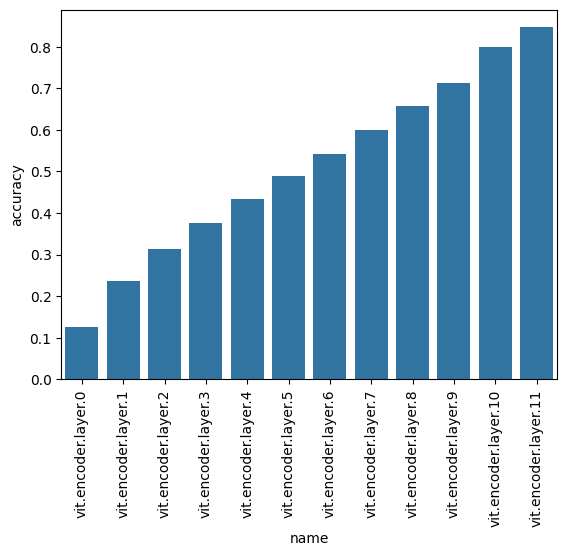

In [13]:
sns.barplot(linear_probe_accuracy, x='name', y='accuracy')
_= plt.xticks(rotation=90)

Probe accuracy smoothly accumulates, as expected. 

Worth noting: the probe accuracy is higher than the trained model's. That may be a result of data leakage, but I don't think so. Instead, I think that this is a sign of poor initialization: the model is a probe-only model, but trained with gradient descent, while the the probes are fit by ridge regression. This seems to indicate that the initial probe should be taken from the ridge regression version. (__Confirmed:__ ridge-regression fits produce models with much better, ~85%, accuracy)

In [18]:
identifiabilityResults

,name,accuracy,identifiability,test
0,vit.encoder.layer.0,0.0075,0.516317,layerwise_model_decoder
1,vit.encoder.layer.1,0.0084,0.532526,layerwise_model_decoder
2,vit.encoder.layer.2,0.0081,0.558976,layerwise_model_decoder
3,vit.encoder.layer.3,0.0111,0.610155,layerwise_model_decoder
4,vit.encoder.layer.4,0.0187,0.658626,layerwise_model_decoder
5,vit.encoder.layer.5,0.0294,0.708623,layerwise_model_decoder
6,vit.encoder.layer.6,0.0454,0.747594,layerwise_model_decoder
7,vit.encoder.layer.7,0.0570,0.767734,layerwise_model_decoder
8,vit.encoder.layer.8,0.0683,0.787933,layerwise_model_decoder
9,vit.encoder.layer.9,0.1019,0.827522,layerwise_model_decoder


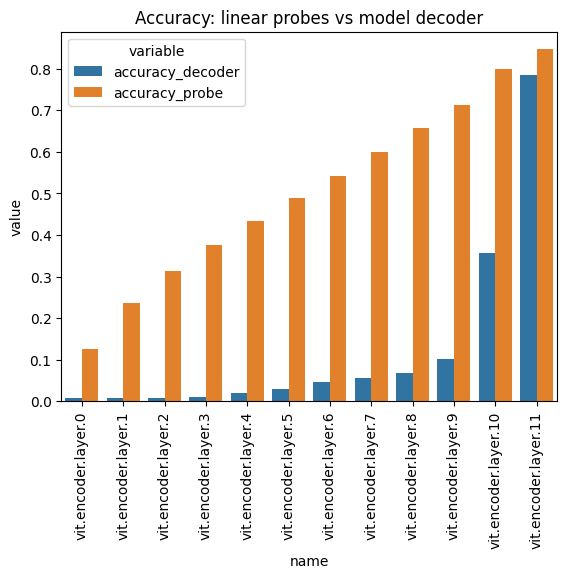

In [20]:
accuracy_comparison = pd.merge(identifiabilityResults.drop(columns=['identifiability','test' ]),
                               linear_probe_accuracy.drop(columns='test'),
                               on='name', suffixes=['_decoder', '_probe']
                       ).melt(id_vars='name')

sns.barplot(accuracy_comparison, x='name', y='value', hue='variable')
plt.title('Accuracy: linear probes vs model decoder')
_= plt.xticks(rotation=90)